# Python Group
## Lab Three: Extending Logistic Regression
### Wali Chaudhary, Bryce Shurts, & Alex Wright

## Preparation and Overview

### (Business) Use-case

As is outlined by Mr. Nansal's dataset description, a salient goal of this dataset was to provide an accurate/representative dataset regarding the failures of machines and other mechanical equipment, as real datasets of such a nature (and of a sufficient quality so as to be predictive) are difficult to find in the wild.

Naturally, this flows into the overall goal of having such a predictive dataset: increasing our ability to monitor potentially dangerous equipment for wear (or other failure conditions) and enact preventative maintenance or usage guidelines for them to prevent this from happening. While in some cases this is more of a financial and business continuity concern, e.g., the operation of an assembly line creating clothing, it can quickly spiral into health and safety concern, both for employees and others that are dependent on such tools doing their job accurately and safely: automated forge equipment, QA testing machines for foods and chemical products and tools used to create load-bearing equipment are just some of these possibilities.

As such, it is of great importance to a business financially, morally, and legally to ensure that they have reliable methods for detecting potential and upcoming failures of equipment, which this dataset could potentially help with should an accurate & generalizable classifier be created around it.

#### Citation & Acknowledgement

The *Machine Predictive Maintenance Classification* dataset is liscenced under the [Creative Commons 1.0 Universal Public Domain](https://creativecommons.org/publicdomain/zero/1.0/) and was provided by Shivam Nansal on [Kaggle](https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification).

### Preprocessing

Before we begin preprocessing, we must first break down the contents of our data and describe the nature and repersentation of each feature:

- UDI - unique ID - categorical; one-hot encoded integer
- Product ID - Another unique identifier - categorical; one-hot encoded integer
- Type - Specifies the quality variant of the product (low, medium, high) - categorical; one-hot encoded integer
- Air temperature [K] - Ambient temp in K at time of sampling - numerical; float
- Process temperature [K] - Synthetic estimate of tool temperature in K generated via stochastic method - numerical; float
- Rotational speed [rpm] - Estimated RPM of tool at time of sampling - numerical; integer
- Torque [Nm] - Output torque of tool in Nm at time of sampling - numerical; float
- Tool wear [min] - Amount of time the tool has been used for in minutes - numerical; integer
- Target - Binary of whether a failure occured - categorical; binary integer/boolean
- Failure Type - Mode of failure, if any: classification target - categorical; one-hot encoded integer

In [939]:
# Handle all imports for notebook

import pandas as pd
from pandas import (DataFrame, Series)
import numpy as np
from numpy import ndarray
from numpy.linalg import pinv
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from skimage.filters import gabor_kernel

# Comparison imports for Dr. Larson's code
from scipy.special import expit
from scipy.optimize import fmin_bfgs
from scipy import stats
from scipy.stats import zscore
from numpy import ma

In [940]:
df: DataFrame = pd.read_csv("predictive_maintenance.csv")

In [941]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


Immediately, we can determine that `UDI` and `Product ID` will not be useful to us, as we do not care about features that are redundant in function to the given row ID (i.e., features that are unique to each sample)

In [942]:
df.drop(["UDI", "Product ID"], axis=1, inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


We can also remove the `Target` feature, as we are looking to solve a multiclass classification problem and leaving this feature in will simply result in leakage where the classifier does not learn the expected relationship between the other features and `Failure Type`.

In [943]:
df.drop("Target", axis=1, inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.1,308.5,1498,49.4,5,No Failure
3,L,298.2,308.6,1433,39.5,7,No Failure
4,L,298.2,308.7,1408,40.0,9,No Failure


Next, we can check for any invalid data, such as missing/null entries and non-sensical numbers (negative time or torque).

In [944]:
print("Missing entries: \n" + str(df.isna().sum()))

print("\nInvalid values: \nTorque: " + str((df["Torque [Nm]"].values < 0).any())
      + "\nTool wear: " + str((df["Tool wear [min]"].values < 0).any()))

Missing entries: 
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Failure Type               0
dtype: int64

Invalid values: 
Torque: False
Tool wear: False


Now that we have checked the data and ensured its validity, we can move on to our dummy encoding of our `Type` feature & label encoding our `Failure Type` target.

In [945]:
df = pd.concat([df, pd.get_dummies(df["Type"])], axis=1)
df.drop("Type", axis=1, inplace=True)
df["Failure Type"] = (df["Failure Type"].astype("category")).cat.codes
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type,H,L,M
0,298.1,308.6,1551,42.8,0,1,0,0,1
1,298.2,308.7,1408,46.3,3,1,0,1,0
2,298.1,308.5,1498,49.4,5,1,0,1,0
3,298.2,308.6,1433,39.5,7,1,0,1,0
4,298.2,308.7,1408,40.0,9,1,0,1,0


## Exceptional Work (Feature Extraction)

(10000, 384)


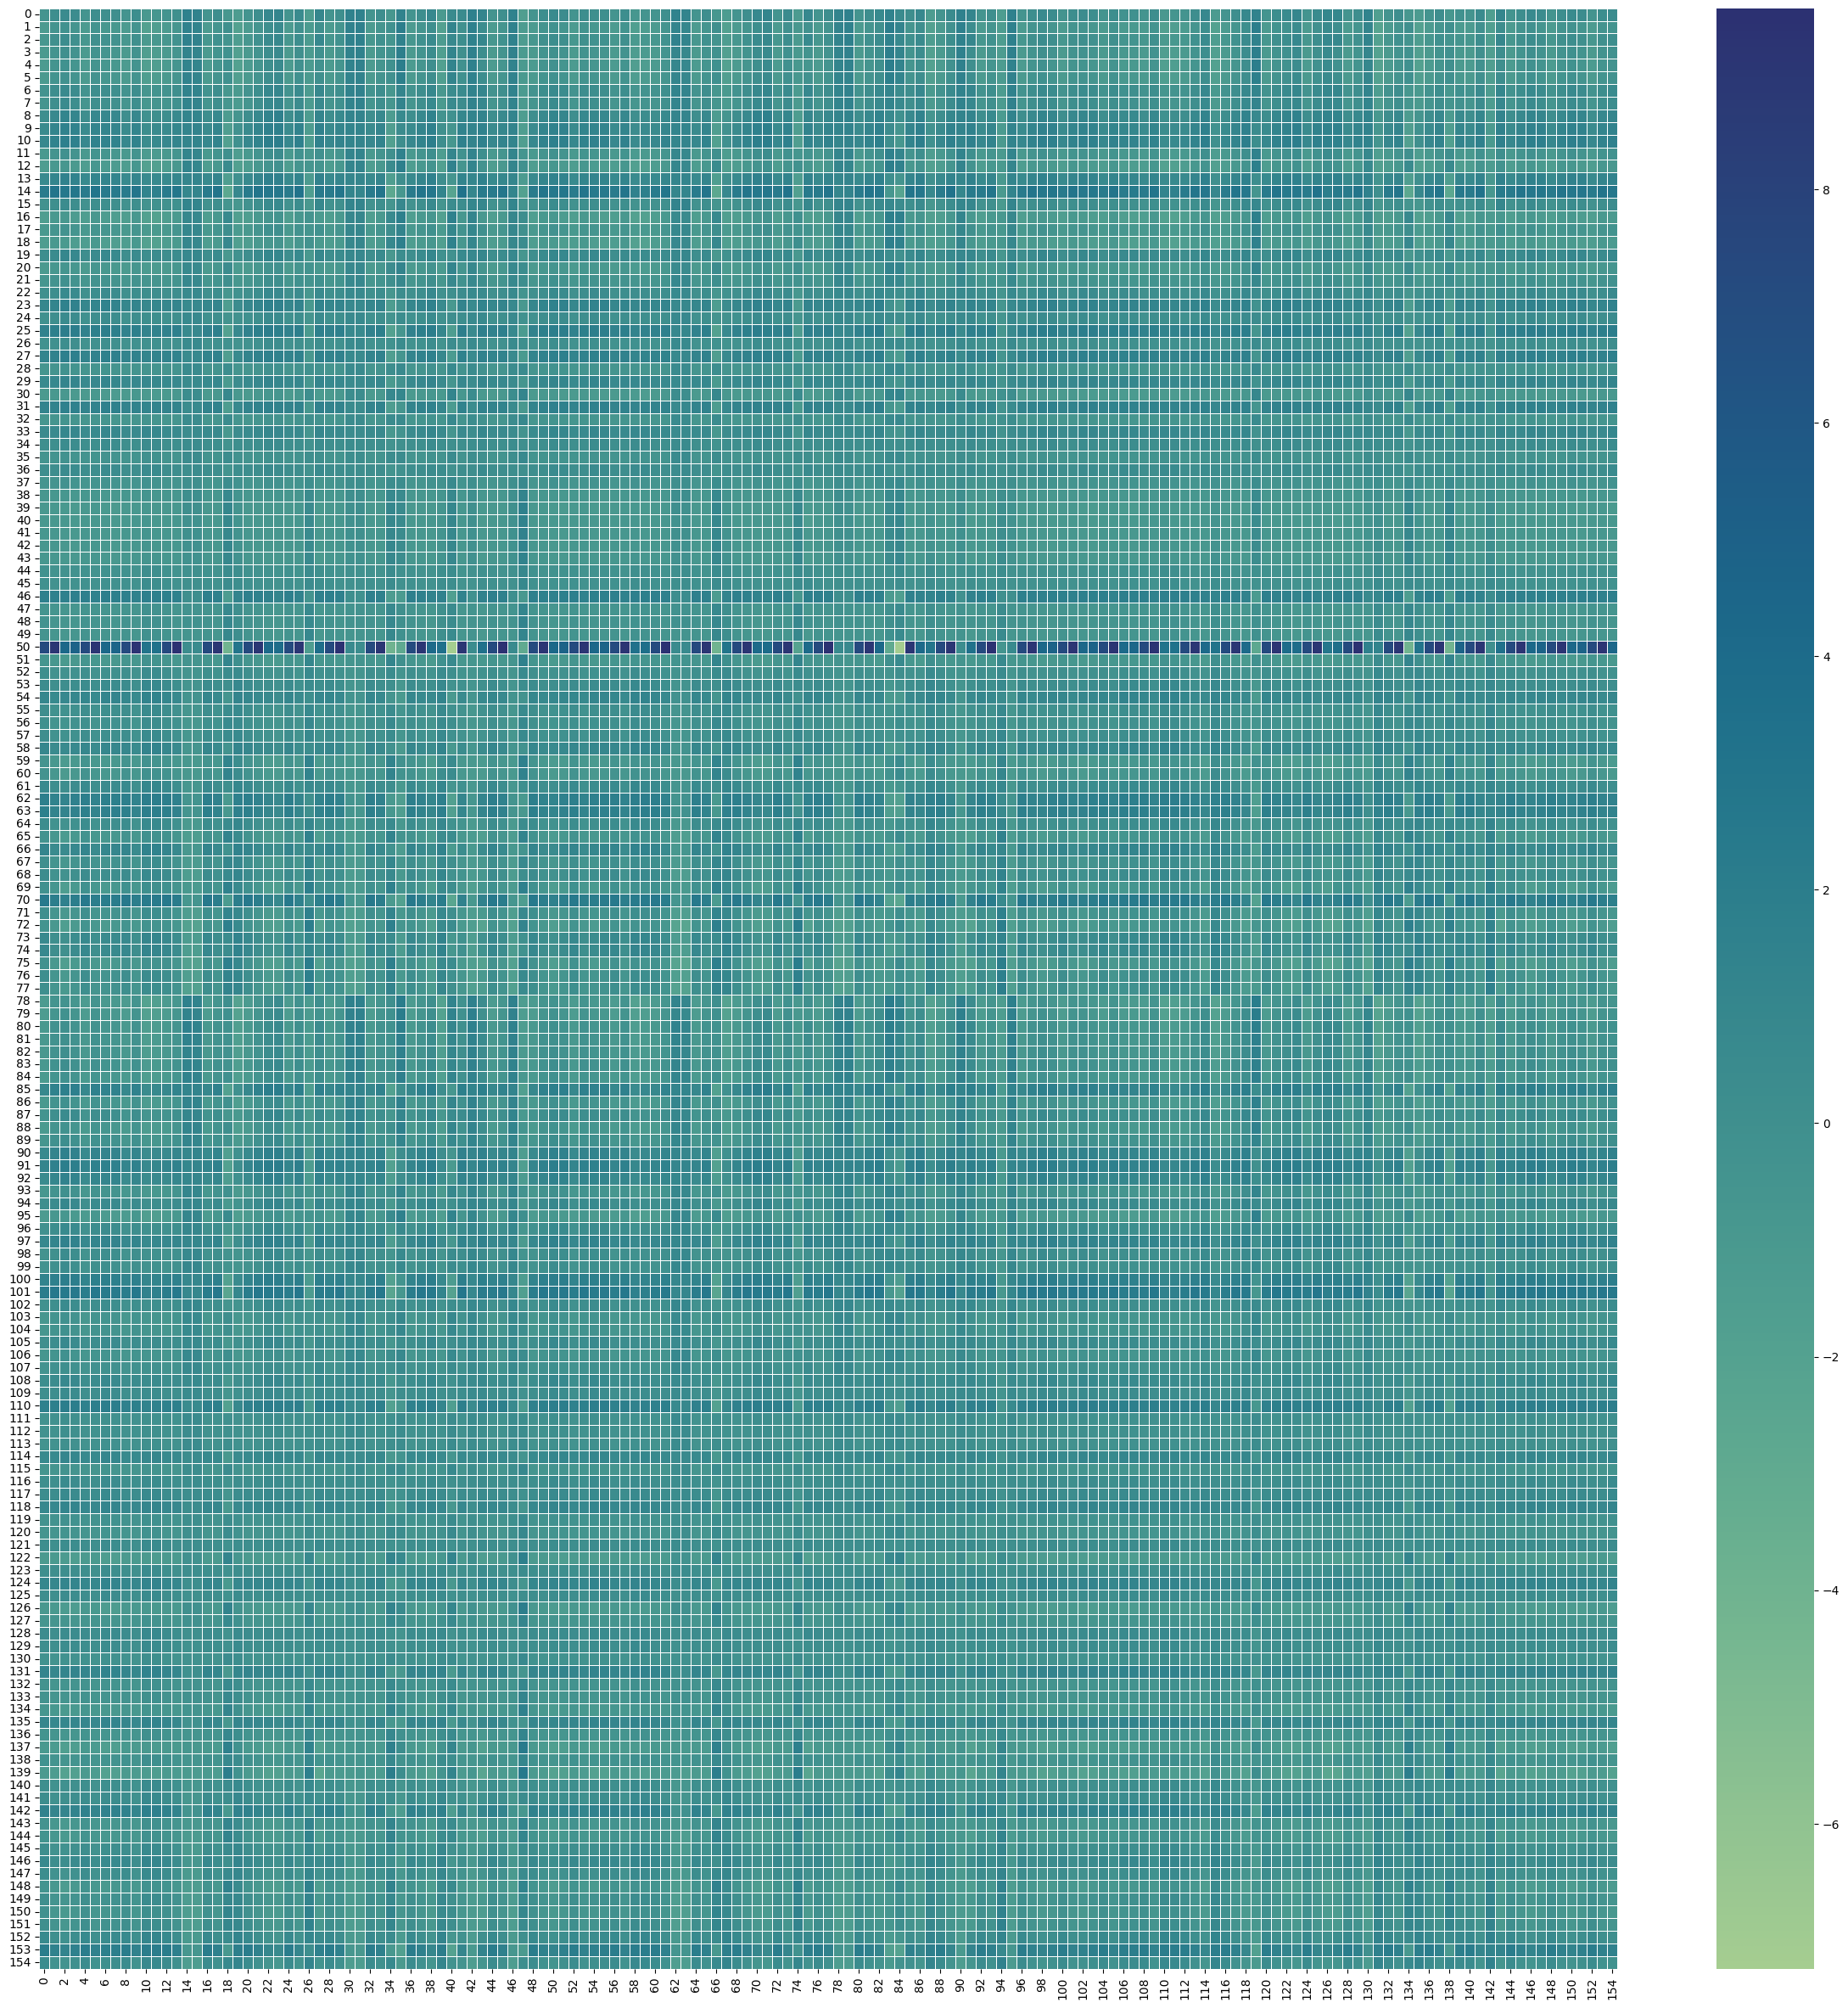

In [947]:
# Gabor Calculation
from scipy import ndimage as ndi

original_shape = (1,8)
rand_idx = 3
acc_logistic = None
images_2 = df.drop("Failure Type", axis=1).to_numpy()
y = df["Failure Type"].to_numpy()

kernels = []
sigma_vals = (1, 3, 5)
frequencies = (0.05, 0.15, 0.25, 0.35)
for theta in range(num_orientations := 8):
    theta = theta / 8. * np.pi    
    for sigma in sigma_vals:
        for frequency in frequencies: 
            kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt    
    return feats.reshape(-1)
# gabr_feature = compute_gabor(images_2[rand_idx], kernels, original_shape)
gabr_feature = compute_gabor(images_2[rand_idx], kernels, original_shape)
gabr_feature.shape

gabor_res = np.array([ compute_gabor(row, kernels, original_shape) for row in images_2 ])

# Pairwise Distances & Heatmap
gabor_pairwise = pairwise_distances(gabor_res)
scaler = StandardScaler()
scaled_pairwise_gabor_imgs = scaler.fit_transform(X=gabor_res, y=None)
print(scaled_pairwise_gabor_imgs.shape)
plt.figure(figsize=(30,30))
sns.heatmap(scaled_pairwise_gabor_imgs[:155, :155], linewidth=.5, cmap="crest")
plt.show()

There exist at least a couple rows with high pairwise distances, meaning that there are potentially outliers to be removed from the data because they do not offer much contribution for our classification purposes. We can use Gabor filters as a kind of heuristic to detect how many outlying features we may have to help us decide in whether we should use L1 or L2 regularization. L1 Regularization allows us to do some feature selection by sparsifying the weights by zeroing out the weights that aren't contributing much to the classification (aka not helping the error calculation become smaller). L2 Regularization penalizes the whole dataset to get rid of outliers and normalizes the amount that any given feature can contribute to an optimization algorithm such as gradient descent. However, the problem is that because L2 Regularization uses Sum of Squared Errors it can start to overly penalize the dataset when it starts to factor in the outliers; it will take those outliers into account and start to overpenalize which causes other features which are more relevant to potentially be masked out because they're so small. The Gabor filters allow us to determine which path of regularization may be a good choice depending on the feature extraction results, we can detect outliers. 


### Test/Training Split
Finally, we are presented with the option of splitting our data into a training & test split. In our case we believe this is the appropiate action to take, as we can train our agent on around 8,000 samples of our data & then cross-validate that it has learned the ground truth relationship between features & the target by attempting to inference the agents against the test data. If the accuracy drops significantly when testing against this test data, then we will know that our model has overfit the data (or otherwise failed to establish the relationship between the feature vectors & the classification vector).

In [77]:
df_train, df_test = train_test_split(df, test_size=0.2)

## Modeling

### One-Verus-All Logistic Regression

In [79]:
class binary_logistic_classifier:
    def __init__(self, learn_rate: float, iterations: int=20, constant: float=0.001, penalty: str=None) -> None:
        self.learn_rate = learn_rate
        self.iterations = iterations
        self.constant = constant
        self.penalty = penalty
    
    @staticmethod
    def _relu(theta: ndarray) -> ndarray:
        # ∀x∈θ max(0, x)
        return np.maximum(0, theta)
    
    @staticmethod
    def _add_bias(data: ndarray) -> ndarray:
        return np.hstack((np.ones((data.shape[0], 1)), data))
    
    def _penalty(self, gradient: ndarray) -> ndarray:
        if self.penalty == None:
            return gradient
        # LASSO
        elif self.penalty == "L1":
            return gradient + self.constant * np.sum(np.abs(self.w_))
        # RIDGE
        elif self.penalty == "L2":
            return gradient + self.constant * np.sum(self.w_**2)
        # Elastic Net
        elif self.penalty == "both":
            return gradient + self.constant * np.sum(self.w_**2) + self.constant * np.sum(np.abs(self.w_))
        else:
            raise Exception("'" + str(self.penalty) +"' not understood.")
    
    
    def predict_probability(self, data: ndarray, add_bias: bool=True) -> float:
        return self._relu((self._add_bias(data) if add_bias else data) @ self.w_)
        
    def predict(self, X: ndarray):
        return self.predict_probability(X) > 0.5
    
    def fit(self, data: ndarray, target: ndarray) -> None:
        data_bias = self._add_bias(data)
        num_samples = data_bias.shape[0] # Rows
        num_features = data_bias.shape[1] # Columns
        self.w_ = np.zeros((num_features, 1))
        
        for _ in range(self.iterations):
            gradient = self._get_gradient(data_bias, target)
            gradient = self._penalty(gradient)
            self.w_ -= self.learn_rate * gradient
            
class multiclass_logistic_classifier:
    def __init__(self, solver: type[binary_logistic_classifier], learn_rate: float, iterations: int=20, constant: float=0.001, penalty: str=None) -> None:
        self.solver = solver
        self.learn_rate = learn_rate
        self.iterations = iterations
        self.constant = constant
        self.penalty = penalty
        
    def predict_probabilities(self, X: ndarray) -> float:
        probabilities = []
        for classifier in self.fit_classifiers:
            probabilities.append(classifier.predict_probability(X).reshape((len(X), 1)))
        return np.hstack(probabilities)
        
    def predict(self, X: ndarray):
        print(self.w_)
        return np.argmax(self.predict_probabilities(X), axis=1)
        
    def fit(self, data: ndarray, targets: ndarray) -> None:
        num_samples = data.shape[0] # Rows
        num_features = data.shape[1] # Columns
        self.unique_target_classes = np.sort(np.unique(targets))
        num_target_classes = len(self.unique_target_classes)
        self.fit_classifiers = []
        
        for _, target in enumerate(self.unique_target_classes):
            target_binary = np.array(targets == target).astype(int)
            
            classifier = self.solver(learn_rate=self.learn_rate, iterations=self.iterations, constant=self.constant, penalty=self.penalty)
            classifier.fit(data, target_binary)
            
            self.fit_classifiers.append(classifier)
        self.w_ = np.hstack([classifier.w_ for classifier in self.fit_classifiers]).T

In [80]:
class steepest_descent(binary_logistic_classifier):
    def _get_gradient(self, X: ndarray, y: ndarray) -> ndarray:
        ydiff = y - self.predict_probability(X, add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # compute gradient using all the training examples
        gradient = gradient.reshape(self.w_.shape)
        
        return gradient
        
class stochastic_descent(binary_logistic_classifier):
    def _get_gradient(self, X: ndarray, y: ndarray) -> ndarray:
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_probability(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        
        return gradient
        
class newton_method(binary_logistic_classifier):
    
    def _calculate_hessian(self, X: ndarray, y: ndarray) -> ndarray:
            pred_weights = self.predict_probability(X, add_bias=False).ravel()
            relu = self._relu(pred_weights)
            grad = relu * (1 - relu)
            hessian = grad @ X ** 2
            return hessian
    
    def _get_gradient(self, X: ndarray, y: ndarray) -> ndarray: 
        pred_weights = self.predict_probability(X, add_bias=False).ravel()
        ydiff = y - pred_weights
        hessian = self._calculate_hessian(X, y)
        
        gradient = np.sum(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)
        return pinv(hessian + np.outer(gradient, gradient)) @ gradient

# The steps for this are detailed in the notebook. Implement them. That is, use BFGS without the use of an external package (for example, do not use SciPy).
# I can only assume that this does not include the restriction of not using numpy...
class bfgs(binary_logistic_classifier):

    def _get_gradient(self, data: ndarray, target: ndarray) -> ndarray:
        target_delta = target - self.predict_probability(data, add_bias=False).ravel()
        gradient = np.mean(data * target_delta[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)
        return -self._penalty(gradient)
    
    def fit(self, data: ndarray, target: ndarray) -> None:
        data_bias = self._add_bias(data)
        num_features = data_bias.shape[1] # Columns
        self.w_ = np.zeros((num_features, 1)).flatten()
        
        # 1. Initial Approx. Hessian for k = 0 is an identity matrix
        k = 0
        H_k = np.identity(len(self.w_))
        Hi_k = H_k # Inverse of I is I
        
        while(np.amax(np.abs(self._get_gradient(data_bias, target))) > 1e-03 and k < self.iterations):
            # 2. Find update diretion p_k
            gradient = self._get_gradient(data_bias, target)
            p_k = -Hi_k @ gradient
            # 3. Update w
            new_weights = self.w_ + self.learn_rate * p_k
            # 4. Save scaled direction
            s_k = self.learn_rate * p_k
            # 5a. Approximate change in derivative
            self.w_ = new_weights
            v_k = self._get_gradient(data_bias, target) - gradient
            # 5b. Define u from above
            #u_k = v_k - (H_k @ s_k)
            # 6. Redefine approx. Hessian
            #H_k = H_k + ((v_k @ v_k.T)/(v_k.T @ s_k)) - (((H_k @ s_k) @ (s_k.T @ H_k))/(s_k.T @ H_k @ s_k))
            # 7. Approximate Inverse Hessian via Sherman Morris
            numerator_one = (s_k[np.newaxis, :] @ v_k[:, np.newaxis] + v_k[np.newaxis, :] @ Hi_k @ v_k[:, np.newaxis]) * (s_k[:, np.newaxis] @ s_k[np.newaxis, :])
            denominator_one = (s_k[np.newaxis, :] @ v_k[:, np.newaxis])**2
            numerator_two = Hi_k @ v_k[:, np.newaxis] @ s_k[np.newaxis, :] + s_k[:, np.newaxis] @ v_k[np.newaxis, :] @ Hi_k
            denominator_two = s_k[np.newaxis, :] @ v_k[:, np.newaxis]
            Hi_k = Hi_k + numerator_one/denominator_one - numerator_two/denominator_two
            # 8. Update k & start from step 2
            k = k + 1
            
        self.w_ = self.w_.reshape((num_features,1))

### Training

In [134]:
%%time
# ds = load_iris()
X = df_train.drop("Failure Type", axis=1)
y = df_train["Failure Type"]
custom_steepest_descent_lr = multiclass_logistic_classifier(solver=steepest_descent, learn_rate=0.001, iterations=10, constant=0.1, penalty="L1")
custom_steepest_descent_lr.fit(X, y)
y_hat = custom_steepest_descent_lr.predict(X)
print("Accuracy: " + str(accuracy_score(y, y_hat)))

[[-2.20010249e-04 -3.41531352e-02 -3.50795102e-02 -1.50618760e-01
  -6.06613525e-03 -1.27337602e-02 -1.17510249e-04 -1.82510249e-04
  -1.35010249e-04]
 [-1.96614779e-02 -2.90556685e+00 -3.00229823e+00 -1.48794227e+01
  -3.92567853e-01 -1.03972023e+00 -1.09902279e-02 -1.57502279e-02
  -1.29389779e-02]
 [-1.60496094e-04 -2.40834961e-02 -2.48967461e-02 -1.08346746e-01
  -4.63249609e-03 -1.67342461e-02 -8.17460937e-05 -1.56746094e-04
  -8.29960937e-05]
 [-1.86479054e-04 -2.63486041e-02 -2.72153541e-02 -1.52821479e-01
  -4.40647905e-03 -8.95397905e-03 -1.02729054e-04 -1.52729054e-04
  -1.28979054e-04]
 [-4.05514515e-05 -6.03592645e-03 -6.23467645e-03 -2.99555515e-02
  -8.73926452e-04 -2.52305145e-03 -2.43014515e-05 -3.43014515e-05
  -2.30514515e-05]
 [-1.00335313e-04 -1.43198353e-02 -1.47905853e-02 -7.60278353e-02
  -1.77208531e-03 -1.03890853e-02 -6.03353126e-05 -7.78353126e-05
  -6.78353126e-05]]
Accuracy: 0.01125
CPU times: user 20.8 ms, sys: 9.38 ms, total: 30.2 ms
Wall time: 22.5 ms


In [132]:
%%time
# ds = load_iris()
X = df_train.drop("Failure Type", axis=1)
y = df_train["Failure Type"]
custom_stochastic_descent_lr = multiclass_logistic_classifier(solver=stochastic_descent, learn_rate=0.001, iterations=10, constant=0.1, penalty="L1")
custom_stochastic_descent_lr.fit(X, y)
y_hat = custom_stochastic_descent_lr.predict(X)
print("Accuracy: " + str(accuracy_score(y, y_hat)))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.11034059e-02 -3.01200341e+00 -3.10920341e+00 -1.65211034e+01
  -3.68603406e-01 -1.29710341e+00 -1.11034059e-02 -1.51034059e-02
  -1.71034059e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
Accuracy: 0.01125
CPU times: user 13.3 ms, sys: 4 ms, total: 17.3 ms
Wall time: 14.5 ms


In [133]:
%%time
# ds = load_iris()
X = df_train.drop("Failure Type", axis=1)
y = df_train["Failure Type"]
custom_newton_lr = multiclass_logistic_classifier(solver=newton_method, learn_rate=0.001, iterations=10, constant=0.1, penalty="L1")
custom_newton_lr.fit(X, y)
y_hat = custom_newton_lr.predict(X)
print("Accuracy: " + str(accuracy_score(y, y_hat)))

[[-1.08999157e-10 -1.69204070e-08 -1.73793587e-08 -7.46206959e-08
  -3.00533103e-09 -6.30865670e-09 -5.82178247e-11 -9.04206208e-11
  -6.68878082e-11]
 [-1.02555523e-12 -1.51556221e-10 -1.56601791e-10 -7.76120183e-10
  -2.04765897e-11 -5.42324705e-11 -5.73257301e-13 -8.21541938e-13
  -6.74905344e-13]
 [-1.51850900e-10 -2.27862279e-08 -2.35556718e-08 -1.02510600e-07
  -4.38296463e-09 -1.58328485e-08 -7.73428041e-11 -1.48302896e-10
  -7.85254723e-11]
 [-9.38194072e-11 -1.32562364e-08 -1.36923066e-08 -7.68859573e-08
  -2.21694203e-09 -4.50483306e-09 -5.16839759e-11 -7.68394572e-11
  -6.48906036e-11]
 [-5.18350942e-10 -7.71545294e-08 -7.96950611e-08 -3.82908323e-07
  -1.11710082e-08 -3.22510304e-08 -3.10634510e-10 -4.38460007e-10
  -2.94656323e-10]
 [-1.98991259e-10 -2.83999918e-08 -2.93336126e-08 -1.50783152e-07
  -3.51451028e-09 -2.06042829e-08 -1.19660760e-10 -1.54367854e-10
  -1.34535229e-10]]
Accuracy: 0.01125
CPU times: user 442 ms, sys: 195 ms, total: 637 ms
Wall time: 282 ms


A breakdown of our hyperparameters and the thinking behind their selection:

- learn_rate: 0.001, A relatively high learning rate (especially compared to values like 1+e-0# which appear to be more typical in ML), which is used in conjuction with the iterations allowed to determine how far we need to be searching forward. Since we are only using 1 iteration, we need to tarvel across our function quickly to converge.
- iterations: 10, Used to match Dr. Larson's iterations used for the sake of time comparisons.
- constant: 0.1, Used to help emphasize the feature selection done by L1 in conjuction with RELU to hopefully sparsify our features quickly & find only the relevant terms. Still not too high at to not mistakenly wipe out relevant features.
- penalty: L1, Since we have few features, outliers are a concern, prompting the usage of L1 to feature select and avoiding L2 since the sum of squares will explode if it runs into an outlier and penalize all of the other features that migth be relevant.

In [955]:
%%time
# ds = load_iris()
X = df_train.drop("Failure Type", axis=1)
y = df_train["Failure Type"]
custom_bfgs_lr = multiclass_logistic_classifier(solver=bfgs, learn_rate=0.001, iterations=10, constant=0.1, penalty="L1")
custom_bfgs_lr.fit(X, y)
y_hat = custom_bfgs_lr.predict(X)
print("Accuracy: " + str(accuracy_score(y, y_hat)))

[[ 1.94761252e-03 -2.47104329e-01 -2.74058171e-01  1.00016301e-01
  -9.64423844e-02  5.94341164e-02  2.53714878e-03  3.17629902e-03
   1.92257497e-03]
 [-9.61896856e-03 -8.19365159e+00 -8.43160694e+00  4.69584498e+00
  -1.05606840e+00  2.05569214e+00  1.34013532e-02  4.87586759e-03
   6.74253400e-03]
 [ 1.41587434e-04 -1.03833600e-01 -1.06437677e-01  4.52186142e-02
  -4.29847245e-03  3.57325297e-02  2.31900186e-04  1.35697453e-03
  -4.78405820e-04]
 [ 1.76289180e-03  3.89865965e-01  4.06400813e-01 -1.67529372e-01
   3.26342481e-01  2.37238729e-02  4.41219080e-04  1.54716736e-03
   5.97560705e-04]
 [ 2.27530910e-04 -3.25944564e-02 -3.32099510e-02  1.81464873e-02
  -1.09716224e-02 -7.12752208e-02  5.25417518e-04  3.65890094e-04
   8.60874060e-06]
 [ 6.08485826e-04  6.49718751e-02  6.72239448e-02 -2.01611871e-02
   2.56154342e-02 -5.50908272e-02  2.94986285e-04  4.77812377e-04
   6.17848353e-04]]
Accuracy: 0.96525
CPU times: total: 62.5 ms
Wall time: 64.5 ms


In [124]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score

X = df_train.drop("Failure Type", axis=1)
y = df_train["Failure Type"]

classifier = LogisticRegression(solver='newton-cg',penalty='l2', max_iter=100)
classifier.fit(X, y)
y_pred = classifier.predict(X)
accuracy_score(y, y_pred)

CPU times: user 4.11 s, sys: 1.03 s, total: 5.15 s
Wall time: 1.82 s


/usr/local/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


0.980625

### Performance Comparison

In [85]:
# I'll start this section since I need to compare performance between BFGS implementations anyways
# Feel free to make stuff above this since the BFGS implementation is the "last" classifer we make if following the instructions

# Using the example BFGS class...

class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

            
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(w**2) 
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))

        
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 solver=BFGSBinaryLogisticRegression):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            hblr = self.solver(eta=self.eta,iterations=self.iters,C=self.C)
            hblr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row


In [953]:
%%time
X = df_train.drop("Failure Type", axis=1)
y_not_binary = df_train["Failure Type"]

bfgs_lr = MultiClassLogisticRegression(eta=1,
                                  iterations=10,
                                  C=0.01,
                                  solver=BFGSBinaryLogisticRegression
                                 )
bfgs_lr.fit(X,y_not_binary)
print(bfgs_lr)

yhat = bfgs_lr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-6.29163163e-04 -1.88702204e-01 -1.95025640e-01 -9.70160828e-01
  -2.50199122e-02 -6.79549317e-02 -6.44449736e-05 -3.73796938e-04
  -1.90921252e-04]
 [ 6.29913133e-04  1.88919241e-01  1.95251857e-01  9.70189856e-01
   2.47614334e-02  6.63639380e-02  6.59191740e-05  3.70128969e-04
   1.93864990e-04]
 [-6.29822879e-04 -1.88937962e-01 -1.95240897e-01 -9.70127719e-01
  -2.50633788e-02 -6.71334296e-02 -6.49639686e-05 -3.71884760e-04
  -1.92974150e-04]
 [-6.32636374e-04 -1.89781035e-01 -1.96114670e-01 -9.69696239e-01
  -2.52360183e-02 -6.83663662e-02 -6.49581991e-05 -3.76192701e-04
  -1.91485474e-04]
 [-6.30806902e-04 -1.89232053e-01 -1.95546333e-01 -9.69934373e-01
  -2.52604693e-02 -6.81285697e-02 -6.40143983e-05 -3.75382331e-04
  -1.91410173e-04]
 [-6.31007020e-04 -1.89290695e-01 -1.95607680e-01 -9.69946990e-01
  -2.52948275e-02 -6.75950952e-02 -6.45330004e-05 -3.75898759e-04
  -1.90575260e-04]]
Accuracy of:  0.96525
CPU times: tot

As we can see from the immediate comparison, we end up with both implementations of BFGS getting the same 96.5% accuracy on our dataset, albeit through a vastly different set of weights. However, we should also consider the speed: both CPU and wall times see a significant slowdown in the scipy implementation, with a speed several (3~4x) times slower than our custom implemntation. Of course, the absolute magnitude of these values is small enough that CPU jitter is going to significantly affect the results, but there are other considerations to keep in mind.

For instance, the scipy implementation computes the inverse hessian through the Sherman-Morrison algorithm just like ours, but where we use the expanded form to avoid computing matrix inverses, they instead utilize these temporary matrices, which may result in inefficiencies. We also do not use a line search algorithm to find our learning rate on each iteration (as it was not delineated as one of the steps in the instructions), and instead we tune an aggregate manually until good results are achieved. This avoids needing to run the line search, but also in effect means needing to run BFGS multiple times to optimize this hyperparameter, effectively making it more difficult to apply with good results and take longer overall.

As such, we would still recommend using the scipy implementation of BFGS, although perhaps an improved version using the expanded Sherman-Morrison formula could be used to increase speed performance?

## Testing

### Scikit-Learn's Logistic Regression Prediction


In [137]:
X = df_test.drop("Failure Type", axis=1)
y = df_test["Failure Type"]
y_pred = classifier.predict(X)
accuracy_score(y, y_pred)

0.984

### Steepest Descent

In [105]:
%%time
# ds = load_iris()
X = df_test.drop("Failure Type", axis=1)
y = df_test["Failure Type"]
# We already have a model/agent fit on the training data
#lr = multiclass_logistic_classifier(solver=bfgs, learn_rate=0.001, iterations=10, constant=0.1, penalty="L1")
#lr.fit(X, y) 
y_hat = custom_steepest_descent_lr.predict(X)
print("Accuracy: " + str(accuracy_score(y, y_hat)))

[[-2.20010249e-04 -3.41531352e-02 -3.50795102e-02 -1.50618760e-01
  -6.06613525e-03 -1.27337602e-02 -1.17510249e-04 -1.82510249e-04
  -1.35010249e-04]
 [-1.96614779e-02 -2.90556685e+00 -3.00229823e+00 -1.48794227e+01
  -3.92567853e-01 -1.03972023e+00 -1.09902279e-02 -1.57502279e-02
  -1.29389779e-02]
 [-1.60496094e-04 -2.40834961e-02 -2.48967461e-02 -1.08346746e-01
  -4.63249609e-03 -1.67342461e-02 -8.17460937e-05 -1.56746094e-04
  -8.29960937e-05]
 [-1.86479054e-04 -2.63486041e-02 -2.72153541e-02 -1.52821479e-01
  -4.40647905e-03 -8.95397905e-03 -1.02729054e-04 -1.52729054e-04
  -1.28979054e-04]
 [-4.05514515e-05 -6.03592645e-03 -6.23467645e-03 -2.99555515e-02
  -8.73926452e-04 -2.52305145e-03 -2.43014515e-05 -3.43014515e-05
  -2.30514515e-05]
 [-1.00335313e-04 -1.43198353e-02 -1.47905853e-02 -7.60278353e-02
  -1.77208531e-03 -1.03890853e-02 -6.03353126e-05 -7.78353126e-05
  -6.78353126e-05]]
Accuracy: 0.011
CPU times: user 5.68 ms, sys: 3.38 ms, total: 9.06 ms
Wall time: 11.8 ms


### Stochastic Descent

In [136]:
%%time
# ds = load_iris()
X = df_test.drop("Failure Type", axis=1)
y = df_test["Failure Type"]
# We already have a model/agent fit on the training data
# lr = multiclass_logistic_classifier(solver=bfgs, learn_rate=0.001, iterations=10, constant=0.1, penalty="L1")
# lr.fit(X, y) 
y_hat = custom_stochastic_descent_lr.predict(X)
print("Accuracy: " + str(accuracy_score(y, y_hat)))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.11034059e-02 -3.01200341e+00 -3.10920341e+00 -1.65211034e+01
  -3.68603406e-01 -1.29710341e+00 -1.11034059e-02 -1.51034059e-02
  -1.71034059e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
Accuracy: 0.011
CPU times: user 5.96 ms, sys: 1.89 ms, total: 7.84 ms
Wall time: 10.7 ms


### Newton Method

In [106]:
%%time
# ds = load_iris()
X = df_test.drop("Failure Type", axis=1)
y = df_test["Failure Type"]
# We already have a model/agent fit on the training data
#lr = multiclass_logistic_classifier(solver=bfgs, learn_rate=0.001, iterations=10, constant=0.1, penalty="L1")
#lr.fit(X, y) 
y_hat = custom_newton_lr.predict(X)
print("Accuracy: " + str(accuracy_score(y, y_hat)))

[[-1.08999157e-10 -1.69204070e-08 -1.73793587e-08 -7.46206959e-08
  -3.00533103e-09 -6.30865670e-09 -5.82178247e-11 -9.04206208e-11
  -6.68878082e-11]
 [-1.02555523e-12 -1.51556221e-10 -1.56601791e-10 -7.76120183e-10
  -2.04765897e-11 -5.42324705e-11 -5.73257301e-13 -8.21541938e-13
  -6.74905344e-13]
 [-1.51850900e-10 -2.27862279e-08 -2.35556718e-08 -1.02510600e-07
  -4.38296463e-09 -1.58328485e-08 -7.73428041e-11 -1.48302896e-10
  -7.85254723e-11]
 [-9.38194072e-11 -1.32562364e-08 -1.36923066e-08 -7.68859573e-08
  -2.21694203e-09 -4.50483306e-09 -5.16839759e-11 -7.68394572e-11
  -6.48906036e-11]
 [-5.18350942e-10 -7.71545294e-08 -7.96950611e-08 -3.82908323e-07
  -1.11710082e-08 -3.22510304e-08 -3.10634510e-10 -4.38460007e-10
  -2.94656323e-10]
 [-1.98991259e-10 -2.83999918e-08 -2.93336126e-08 -1.50783152e-07
  -3.51451028e-09 -2.06042829e-08 -1.19660760e-10 -1.54367854e-10
  -1.34535229e-10]]
Accuracy: 0.011
CPU times: user 5.12 ms, sys: 2.52 ms, total: 7.64 ms
Wall time: 9.14 ms


### BFGS

In [957]:
%%time
# ds = load_iris()
X = df_test.drop("Failure Type", axis=1)
y = df_test["Failure Type"]
# We already have a model/agent fit on the training data
#lr = multiclass_logistic_classifier(solver=bfgs, learn_rate=0.001, iterations=10, constant=0.1, penalty="L1")
#lr.fit(X, y) 
y_hat = custom_bfgs_lr.predict(X)
print("Accuracy: " + str(accuracy_score(y, y_hat)))

[[ 1.94761252e-03 -2.47104329e-01 -2.74058171e-01  1.00016301e-01
  -9.64423844e-02  5.94341164e-02  2.53714878e-03  3.17629902e-03
   1.92257497e-03]
 [-9.61896856e-03 -8.19365159e+00 -8.43160694e+00  4.69584498e+00
  -1.05606840e+00  2.05569214e+00  1.34013532e-02  4.87586759e-03
   6.74253400e-03]
 [ 1.41587434e-04 -1.03833600e-01 -1.06437677e-01  4.52186142e-02
  -4.29847245e-03  3.57325297e-02  2.31900186e-04  1.35697453e-03
  -4.78405820e-04]
 [ 1.76289180e-03  3.89865965e-01  4.06400813e-01 -1.67529372e-01
   3.26342481e-01  2.37238729e-02  4.41219080e-04  1.54716736e-03
   5.97560705e-04]
 [ 2.27530910e-04 -3.25944564e-02 -3.32099510e-02  1.81464873e-02
  -1.09716224e-02 -7.12752208e-02  5.25417518e-04  3.65890094e-04
   8.60874060e-06]
 [ 6.08485826e-04  6.49718751e-02  6.72239448e-02 -2.01611871e-02
   2.56154342e-02 -5.50908272e-02  2.94986285e-04  4.77812377e-04
   6.17848353e-04]]
Accuracy: 0.965
CPU times: total: 15.6 ms
Wall time: 4.01 ms


With only ~2000 samples the time remains, as expected, fairly small (especially since we are only inferencing and not training), but achieving a nearly identical accuracy on the testing dataset than the training dataset is a great result! It appears that we were able to successfully meet our goal of creating an accurate & robust classifier, at least as far as the BFGS algorithm implementation is concerned.

We can also see that the Scikit-Learn classifier improves upon our own classifiers with a 98.4% accuracy on the testing data. Our Scikit learn classifier used the 'newton-cg' solver with L2 regularization, and with maximum iteration count of 100. Although our implementations used various optimization techniques, Scikit-Learn still managed to outperform our own implementations; this could be attributed to the implementation details of Scikit learns algorithms being well tested and optimized for performance. Scikit learn also has many more tuneable parameters than our own Classifiers, which increases its versatility in creating better models.

## Deployment

I would use Scikit-Learn's implementation because most algorithms are implemented in C++ and they do not use the standard Python interpreter as a base for their implementation. They also provide much better error messages and debugging information, and the community for SciKit-Learn is enormous and many people are familiar with its API. Hence, if one has a question about some issue or about a bug in the implementation, there exists a lot of people willing to help. Also the development team for Scikit-Learn is highly active and patching fixes and optimizations actively.